# Introduction: simulating a periodic dipole

In this tutorial, we will simulate a simple (periodic) dipole in vacuum. We'll compute important *real-space* quantities, like the light extraction efficiency and the integrated far-field.

Specifically, we'll examine how simulating structures using FMM is different than other discretization techniques (e.g. FDTD) as it expands both the fields and the structure on a *Fourier basis*. Since we typically describe our simulation structure in the *real-space* domain, there are various ways one can represent the structure on a Fourier basis.

We also explore how to perform a *convergence check*, which is important for all numerical methods that attempt to discretize Maxwell's equations. In the context of FMM, this means gradually increasing the number of *Fourier terms* (or basis elements) and examining how some fundamental quantity (e.g. reflection, transmission) changes.

Finally, we show how we can visualize the steady-state field response in the *real-space* domain, even though it is computed in the Fourier domain.

## Setting up the simulation

We want to simulate a simple periodic array of dipoles in a vacuum. Let's establish the following simulation parameters:
* Unit cell has (x, y, z) dimensions of (1400 nm, 1400 nm, 1200 nm).
* The x and y directions have periodic boundary conditions (with no Bloch phase).
* The z direction has an *open* boundary condition (both above and below).
* The permittivity of vacuum is $\varepsilon=1$
* The source is described by an *x-oriented* dipole emitting at 620 nm and is placed in the *center* of the unit cell.

First, let's define our FMM basis, which is defined by a pair of `LatticeVectors`. We can define our `LatticeVectors` either in real space, or in reciprocal space. In this simple example, where we wish to define a simple cubic lattice structure, we'll do so in real space using $\hat{x}$- and $\hat{y}$-oriented vectors scaled by the unit-cell size (the `pitch`).

FMMAX uses *natural units*. Since Maxwell's equations are scale-invariant, we can arbitrarily choose a lengthscale for all of our simulation parameters. The only requirement is that we remain consistent when defining all dimensionfull quantities.

For this tutorial, let's specify all quantities involving length (including wavelength) in *microns* ($\mu\mathrm{m}$)

In [2]:
from fmmax import basis

pitch = 1.4 # microns
height = 1.2 #microns
primitive_lattice_vectors = basis.LatticeVectors(
    u=pitch * basis.X, v=pitch * basis.Y
)

Using the basis, we can define a corresponding *expansion* which is used to represent both the field and geometry in Fourier space. In addition to our basis, we need to choose a finite *number of terms* used to represent this expansion (`approximate_number_of_terms`) and a *truncation method*

The number of terms is the *total* number of terms in both dimensions. FMMAX will do its best to expand onto that exact number. But in order to maintain a symmetric expansion, the total number of terms may differ from what is specified.

The truncation describes how one should choose the set of lattice vectors. A `CIRCULAR` truncation will generate a set of lattice vectors that are lying within a circular region. A `PARALLELOGRAMIC` truncation will do the same, but for an area described by a parallelogram.

For this example, let's choose a `CIRCULAR` truncation with `200` terms.

In [3]:
approximate_num_terms = 200
expansion = basis.generate_expansion(
    primitive_lattice_vectors=primitive_lattice_vectors,
    approximate_num_terms=approximate_num_terms,
    truncation=basis.Truncation.CIRCULAR,
)

Next, we need to define our Bloch phase, or an `in_plane_wavevector` that describes the phase relationship from one side of the unit cell to the other side. In this example, we'll enforce standard periodic boundary conditions (so no extra Bloch phase).

In [4]:
import jax.numpy as jnp

in_plane_wavevector = jnp.zeros((2,))

We can now define our (periodic) dipole source located at the center of our unit cell. We note that there are a few nuances to defining a source like this within an FMM framework.

First, a dipole source is an infinite superposition of many planewave sources. We need to *expand* the dipole source (a spatial delta function) onto our FMM basis. the `sources.dirac_delta_source()` function does exactly that.

Second, we want the source to propagate in *both* directions (top and bottom). These are commonly referred to as *embedded sources*, and will require some care later when we actually propagate the sources through the stack.

In [5]:
from fmmax import sources

dipole = sources.dirac_delta_source(
    location=jnp.asarray([[pitch / 2, pitch / 2]]),
    in_plane_wavevector=in_plane_wavevector,
    primitive_lattice_vectors=primitive_lattice_vectors,
    expansion=expansion,
)

Next, we'll define the geometry (vacuum). If we want to center the dipole source in the z direction, we need to specify two layers of equal width, such that the dipole resides *between* these two layers.

FMMAX needs to solve for all the eigenmodes of each layer. Since the layer above and below the dipole are the same, we only need to solve for *one* layer (and cache the results for the other layer.) Furthermore, since vacuum is *isotropic*, we can use the `fmm.eigensolve_isotropic_media()` function.

To help with numerical convergence, we add a negligble amount of loss to the vacuum permittivity. Since the layer is homogenous (no extra patterning) we ensure the shape of our `permittivity` array is `(1,1)`. FMMAX can analytically compute the eigenmodes in this case.

The `wavelength` parameter is also passed as an array. Future tutorials will explore how one can batch over multiple wavelengths efficiently.

In [6]:
from fmmax import fmm

wavelength = jnp.asarray(0.620)
permittivity = jnp.asarray([[(1.0 + 0.0001j) ** 2]])
formulation = fmm.Formulation.FFT
layer_solve_result = fmm.eigensolve_isotropic_media(
    wavelength = wavelength,
    in_plane_wavevector = in_plane_wavevector,
    primitive_lattice_vectors = primitive_lattice_vectors,
    permittivity = permittivity,
    expansion = expansion,
    formulation = formulation
)

layer_thickness = height / 2.0

We can now compute scattering matrices that relate the forward- and backward-propagating eigenmodes in each layer. There are multiple scattering matrix routines within FMMAX with various levels of abstraction. In this particular case, we want to compute a scattering matrix for each layer independently (i.e. we *don't* want to cascade the layers together *yet*). This way, we can *embed* our dipole source between the layers (and their scattering matrices).

In [7]:
from fmmax import scattering

s_matrix_before_source = scattering.stack_s_matrix(
    layer_solve_results=[layer_solve_result],
    layer_thicknesses=[layer_thickness],
)

# The layers are identical
s_matrix_after_source = s_matrix_before_source

Finally, we can propagate the dipole source into each of these layers by properly exciting the corresponding eigenmodes and cascading the result. The `sources.amplitudes_for_source()` function will properly convert the dipole electric current sources to the corresponding Fourier field amplitudes and propagate them along both directions (top and bottom in this context).

In [8]:
(
    _,
    _,
    bwd_amplitude_before_end,
    fwd_amplitude_after_start,
    _,
    _,
) = sources.amplitudes_for_source(
    jx=dipole,
    jy=jnp.zeros_like(dipole),
    jz=jnp.zeros_like(dipole),
    s_matrix_before_source=s_matrix_before_source,
    s_matrix_after_source=s_matrix_after_source,
)

And that's it! We've successfully simulated a periodic dipole in vacumm. The `bwd_amplitude_before_end` quantity consists of all the Fourier terms that describe the *backward* propagating eigenmodes just before the end of the first layer. In this case, that corresponds to the "upward" propagating waves just above the source itself (i.e. just above the bottom interface of the top layer).

Similarly, the `fwd_amplitude_after_start` quantity consists of the Fourier terms that describe the *forward* propagating eigenmodes just after the start of the last layer. In this case, that corresponds to the "downward" propagating waves just below the source (i.e. just below the top interface of the bottom layer).

The "forward" and "backward" naming conventions may appear confusing at first, but it's intended to avoid ambiguity. Later tutorials will describe much more complicated layer stacks that can be arbitrarily defined (eg. top-to-bottom or bottom-to-top). This naming convention ensures that the Fourier amplitudes can be properly interpreted regardless of the problem formulation.

Finally, we note that these Fourier amplitudes themselves aren't very useful. In the next, section, we'll explore how we can compute various important real-space quantities from these Fourier amplitudes directly.

## Postprocessing

Now that we've simulated the structure itself, let's discuss some of the various quantities we may want to extract. Specifically, let's do the following:

* Compute the upward extraction efficiency.
* Extract the X/Y nearfields 500 nm above the dipole

Mesh setting: 10 nm for x, y, z

### Extraction efficiency

To properly compute the extraction efficiency, we need to compute the power propagating upward *normalized* by the power emitted by the dipole source itself.

In [9]:
from fmmax import fields

# Compute the Poynting flux before and after the source
fwd_flux, bwd_flux= fields.directional_poynting_flux(
    forward_amplitude=fwd_amplitude_after_start,
    backward_amplitude=bwd_amplitude_before_end,
    layer_solve_result=s_matrix_before_source.end_layer_solve_result,
)

# Compute total power emitted by the source by summing over the Brillouin Zone.
forward_emitted_power = jnp.sum(fwd_flux)
backward_emitted_power = -jnp.sum(bwd_flux)
total_emitted_power = forward_emitted_power + backward_emitted_power

# The total extracted power is the forward emitted power.
total_extracted_power = forward_emitted_power

# Calculate the extraction efficiency.
extraction_efficiency = total_extracted_power / total_emitted_power
print(extraction_efficiency)

0.5


### Near-field profiles

We also have the option to visualize the near-field profiles. Given that the amplitudes we've computed thus far are in the Fourier domain, it's necessary to transform them into fields on a Cartesian grid prior to visualization. The `fields.layer_fields_3d()` function is ideally suited for this purpose.

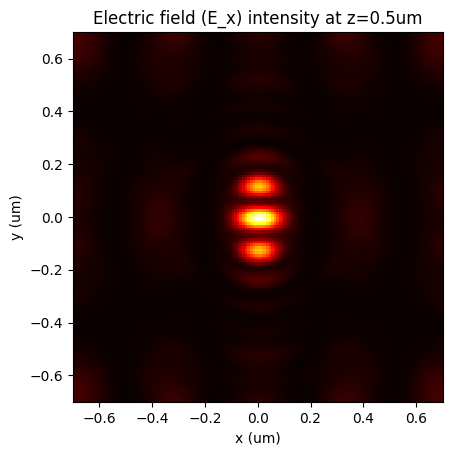

In [64]:
import matplotlib.pyplot as plt

# Define mesh size and number of grid points in x and y.
mesh_size = 0.01
xy_n_grid = int(pitch / mesh_size)
z_n_grid = int(height / mesh_size)

# Compute the fields in the cartesian coordinates.
(ef, hf, (x, y, z)) = fields.layer_fields_3d(
    forward_amplitude_start=fwd_amplitude_after_start,
    backward_amplitude_end=bwd_amplitude_before_end,
    layer_solve_result=s_matrix_before_source.end_layer_solve_result,
    layer_thickness=layer_thickness,
    layer_znum=z_n_grid,
    grid_shape=(xy_n_grid, xy_n_grid),
    num_unit_cells=(1, 1)
)

# Take a cross section of the electric field at z = 0.5um (140th grid point)
cross_section = ef[0, :, :, 140, 0]
extent = [-pitch / 2, pitch / 2, -pitch / 2, pitch / 2]
plt.imshow(jnp.abs(cross_section)**2, cmap='hot', interpolation='nearest', extent=extent)
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title('Electric field (E_x) intensity at z=0.5um')
plt.show()

## Convergence checks

We can enhance the resolution of smaller field details and subsequently improve the simulation accuracy by increasing the number of Fourier terms. However, this comes with the trade-off of increased computational complexity and memory usage. To better understand this balance, it may be beneficial to perform a convergence test.

Let's reuse our previously written code for the `plot_cross_section()` function below. We then visualize the 2d cross-section with respect to different `approximate_num_terms` values.

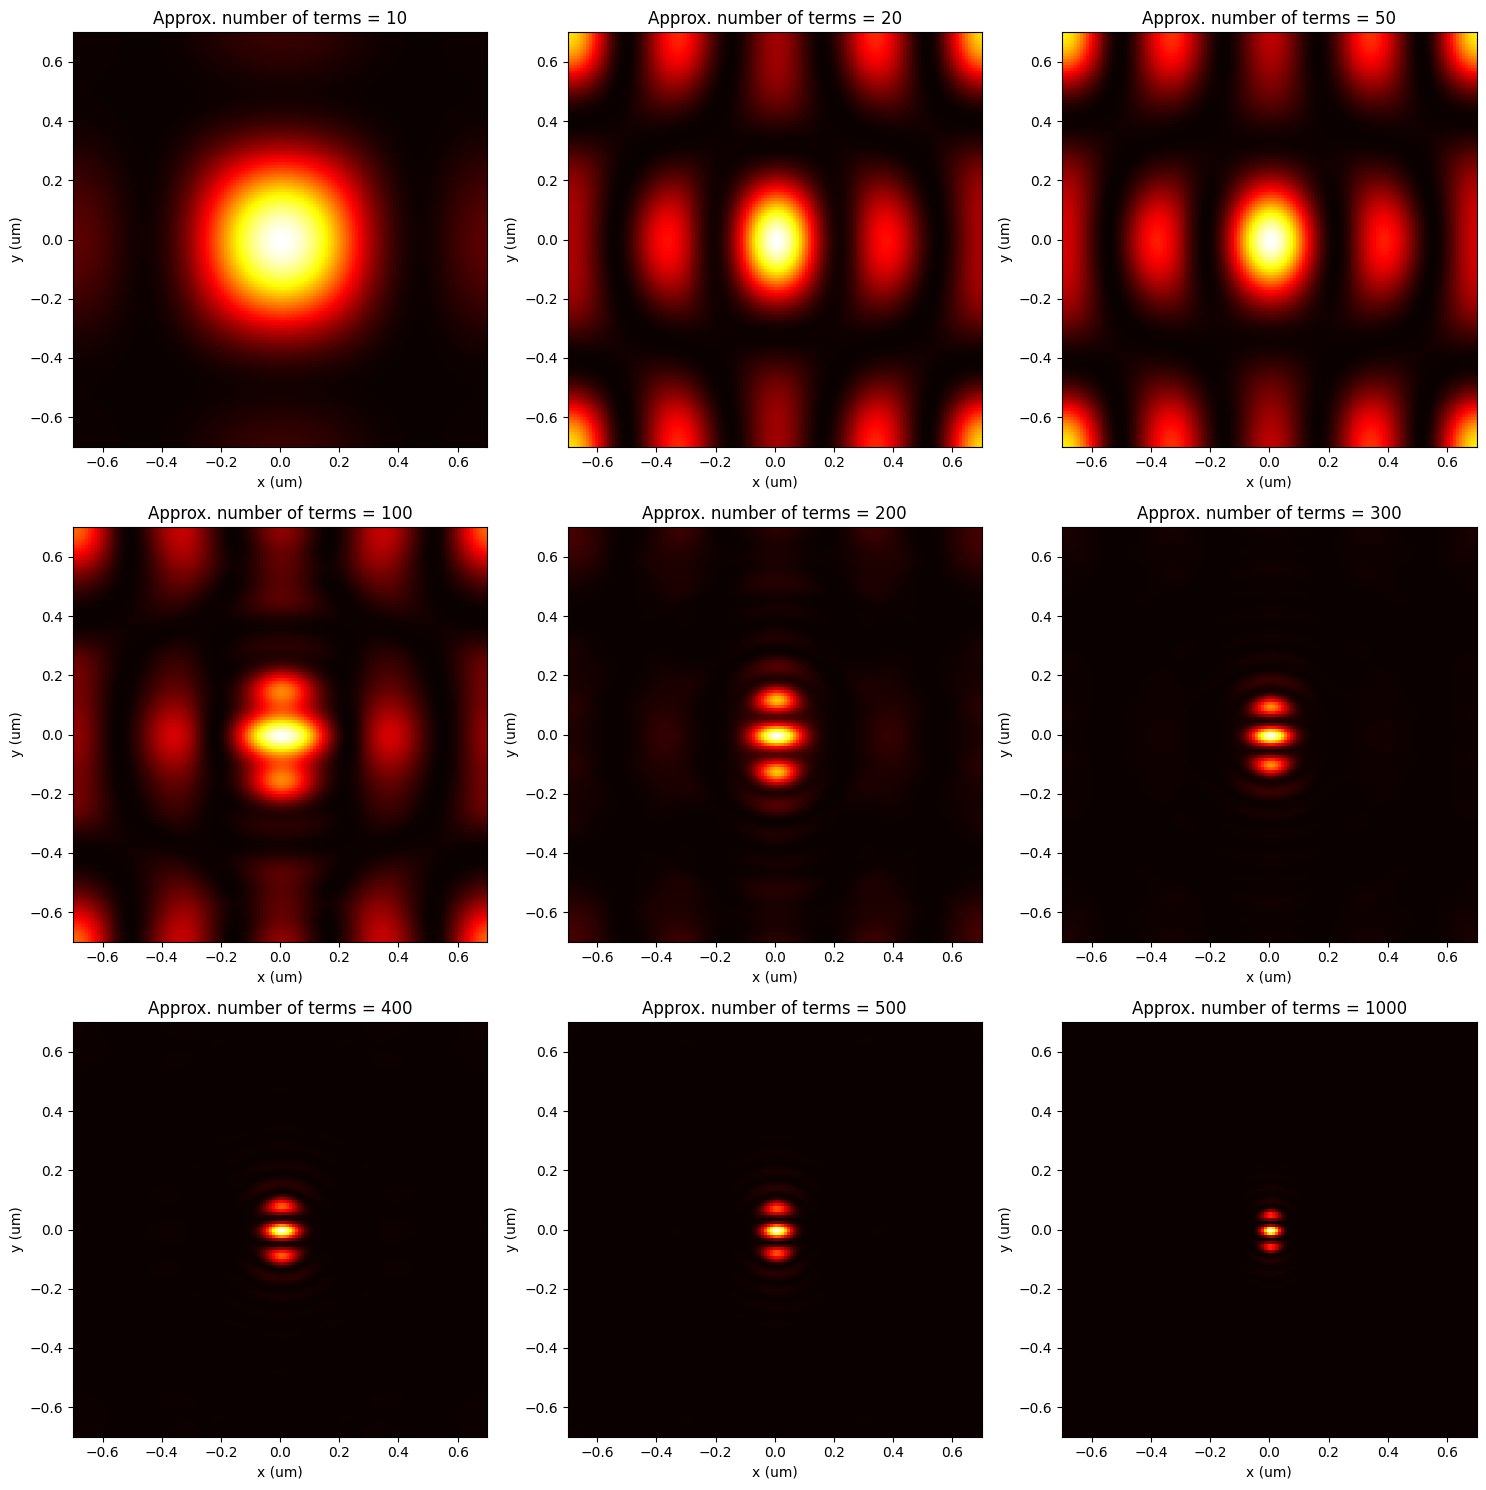

In [78]:
from fmmax import basis, sources, fmm, scattering, fields

import matplotlib.pyplot as plt
def plot_cross_section(num_terms: int, ax: plt.Axes) -> None:
    """Helper function to plot the cross section of the electric field intensity.
    
    Args:   
        num_terms: Number of terms in the expansion
        ax: Matplotlib axes object
    """
    # Define simulation parameters
    pitch = 1.4  # microns
    height = 1.2  # microns
    mesh_size = 0.01
    xy_n_grid = int(pitch / mesh_size)
    z_n_grid = int(height / mesh_size)

    # Set up the simulation
    expansion = basis.generate_expansion(
        primitive_lattice_vectors=primitive_lattice_vectors,
        approximate_num_terms=num_terms,
        truncation=basis.Truncation.CIRCULAR,
    )

    dipole = sources.dirac_delta_source(
        location=jnp.asarray([[pitch / 2, pitch / 2]]),
        in_plane_wavevector=in_plane_wavevector,
        primitive_lattice_vectors=primitive_lattice_vectors,
        expansion=expansion,
    )

    wavelength = jnp.asarray(0.620)
    permittivity = jnp.asarray([[(1.0 + 0.0001j) ** 2]])
    formulation = fmm.Formulation.FFT
    layer_solve_result = fmm.eigensolve_isotropic_media(
        wavelength=wavelength,
        in_plane_wavevector=in_plane_wavevector,
        primitive_lattice_vectors=primitive_lattice_vectors,
        permittivity=permittivity,
        expansion=expansion,
        formulation=formulation
    )

    layer_thickness = height / 2.0

    s_matrix_before_source = scattering.stack_s_matrix(
        layer_solve_results=[layer_solve_result],
        layer_thicknesses=[layer_thickness],
    )

    # The layers are identical
    s_matrix_after_source = s_matrix_before_source

    (
        _,
        _,
        bwd_amplitude_before_end,
        fwd_amplitude_after_start,
        _,
        _,
    ) = sources.amplitudes_for_source(
        jx=dipole,
        jy=jnp.zeros_like(dipole),
        jz=jnp.zeros_like(dipole),
        s_matrix_before_source=s_matrix_before_source,
        s_matrix_after_source=s_matrix_after_source,
    )

    # Compute the fields in the cartesian coordinates
    (ef, hf, (x, y, z)) = fields.layer_fields_3d(
        forward_amplitude_start=fwd_amplitude_after_start,
        backward_amplitude_end=bwd_amplitude_before_end,
        layer_solve_result=s_matrix_before_source.end_layer_solve_result,
        layer_thickness=layer_thickness,
        layer_znum=z_n_grid,
        grid_shape=(xy_n_grid, xy_n_grid),
        num_unit_cells=(1, 1)
    )

    # Plot the cross section
    cross_section = ef[0, :, :, 140, 0]
    extent = [-pitch / 2, pitch / 2, -pitch / 2, pitch / 2]
    ax.imshow(jnp.abs(cross_section) ** 2, cmap='hot', interpolation='nearest', extent=extent)
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    ax.set_title(f'Approx. number of terms = {num_terms}')

n_term_list = [10, 20, 50, 100, 200, 300, 400, 500, 1000]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, n_term in enumerate(n_term_list):
    plot_cross_section(n_term, axs.ravel()[i])
plt.tight_layout()
plt.show()
